# Exploratory notebook 

## 42186 Model-based Machine Learning 

#### Malene Plauborg (s174301), Katinka Klepsch (s174313)

## Data

Data sources used for the project:

https://data.mendeley.com/datasets/b5r4yztghx/2
<br> https://www.kaggle.com/code/muonneutrino/mapping-new-york-city-census-data/data
<br> https://www.kaggle.com/code/muonneutrino/mapping-new-york-city-census-data/data?select=nyc_census_tracts.csv


## Load packages

In [24]:
#Load packages
import numpy as np
import pandas as pd   # We import Pandas!
from matplotlib import pyplot as plt
from sklearn import linear_model
import torch
import seaborn as sns

In [ ]:
# Load data
df_acc = pd.read_csv("data/bym_nyc_study.csv")  
df_census = pd.read_csv("data/nyc_census_tracts.csv",index_col=0)  
blocks = pd.read_csv('data/census_block_loc.csv')

## Data preprocessing

In order to make some demographic distributions, some preprocessing of the given data must be made.
<br> The dataframes are firstly merged using the census tract id "Tract".

In [29]:
# Data mapping
blocks = blocks[blocks.County.isin(['Bronx','Kings','New York','Queens','Richmond'])]
blocks['Tract'] = blocks.BlockCode // 10000
blockss = blocks.merge(df_census,how='left',right_index=True,left_on='Tract')

In [31]:
df_ = df_acc[['census_tract', 'ped_injury_5to18','youth_pop_5to18']]
df_mapping = pd.merge(blockss, df_, how="left", left_on='Tract', right_on='census_tract')  

In [34]:
# Data for modelling - no coordinates
df_merged = df_acc.merge(df_census, left_on='census_tract', right_index=True)
df_merged.to_csv('data/data_merged.csv', index=False)  

In [36]:
attributes = ['ped_injury_5to18','County', 'youth_pop_5to18','commute_priv_vehicle', 'med_hhincome', 'avg_ann_daily_traffic','fragment_index']
df_viz = df_merged[df_merged.columns[df_merged.columns.isin(attributes)]]

## Data visualisation
Now an exploratory analysis of the data is performed.

### Demographic distributions
It is interesting to investigate the demographic distributions of the youth population and pedestrian injuries and compare these to each other. It is expected that areas with a larger youth population will have more pedestrian injuries.  

In [12]:
# plots to make demographic visualisation and use coordinates

def make_plot(data_values,title='',colors='Greens'):
    lat_vals,lon_vals,values = convert_to_2d(blocks.Latitude,blocks.Longitude,data_values)
    fig = plt.figure(1,figsize=[10,10])
    limits = np.min(lon_vals),np.max(lon_vals),np.min(lat_vals),np.max(lat_vals)
    
    im = plt.imshow(values.T,origin='lower',cmap=colors,extent=limits)
    plt.xlabel('Longitude [degrees]')
    plt.ylabel('Latitude [degrees]')
    plt.title(title)
    plt.colorbar(im,fraction=0.035, pad=0.04)
    
    plt.show()
    
def convert_to_2d(lats,lons,values):
    latmin = 40.48
    lonmin = -74.28
    latmax = 40.93
    lonmax = -73.65
    lon_vals = np.mgrid[lonmin:lonmax:200j]
    lat_vals = np.mgrid[latmin:latmax:200j]
    map_values = np.zeros([200,200])
    dlat = lat_vals[1] - lat_vals[0]
    dlon = lon_vals[1] - lon_vals[0]
    for lat,lon,value in zip(lats,lons,values):
        lat_idx = int(np.rint((lat - latmin) / dlat))
        lon_idx = int(np.rint((lon-lonmin) / dlon ))        
        if not np.isnan(value):
            map_values[lon_idx,lat_idx] = value
    return lat_vals,lon_vals,map_values

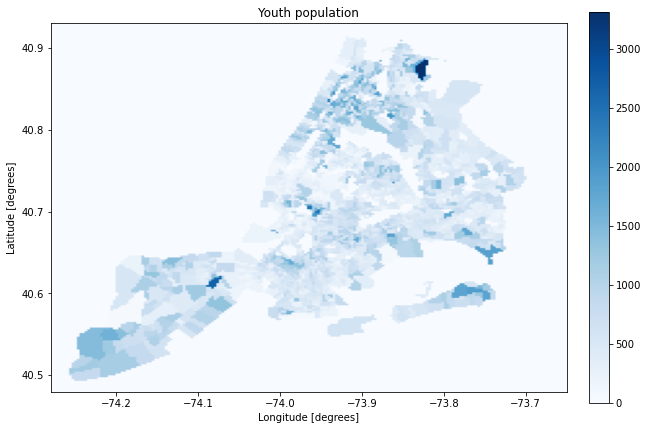

In [23]:
make_plot(df_mapping.youth_pop_5to18,colors='Blues',title='Youth population')

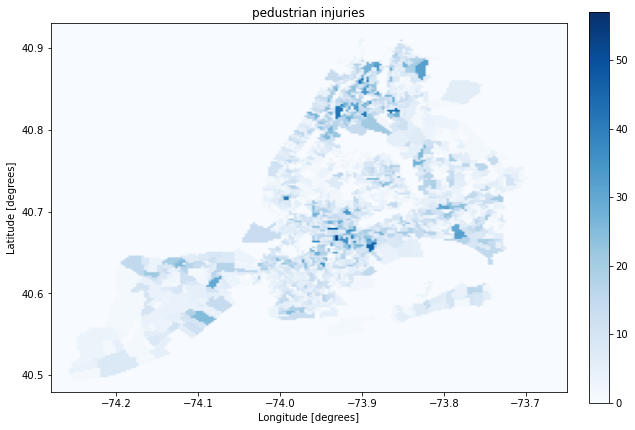

In [24]:
make_plot(df_mapping.ped_injury_5to18,colors='Blues',title='pedustrian injuries')

To our suprise we do not see a tendency of more injuries in areas with larger youth population. However, it can be seen that the areas that have the highest number of injury events are areas with a low population. When looking at the map these areas can be identified to parks and as many young people hang out here it makes good sense that the number of injuries are larger around these areas.

## Areal distribution of census tracts

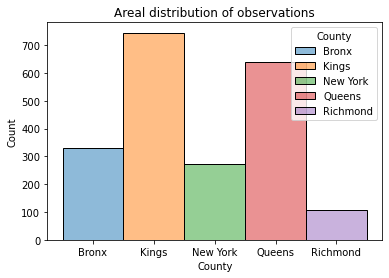

In [49]:
fig, ax = plt.subplots(1,1)

sns.histplot(df_viz, x="County", binwidth=3, hue = 'County')

plt.title("Areal distribution of observations")
plt.show()

We can see that the most census tracts have been made in King and Queens. Lowest amounts of census tract have happened in Richmond.

## Areal distribution of pedestrian injuries

The pedestrian injuries are now investigated in the different areas.

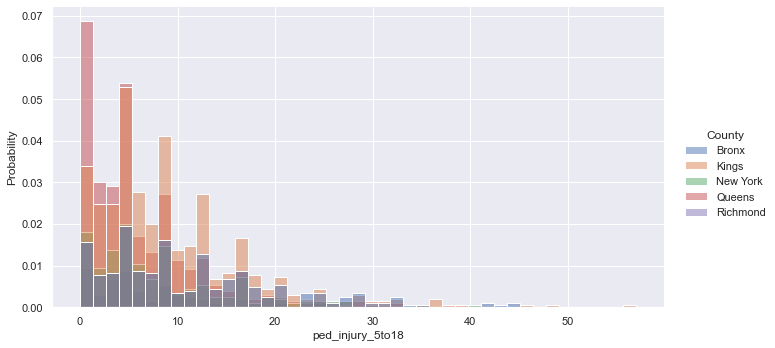

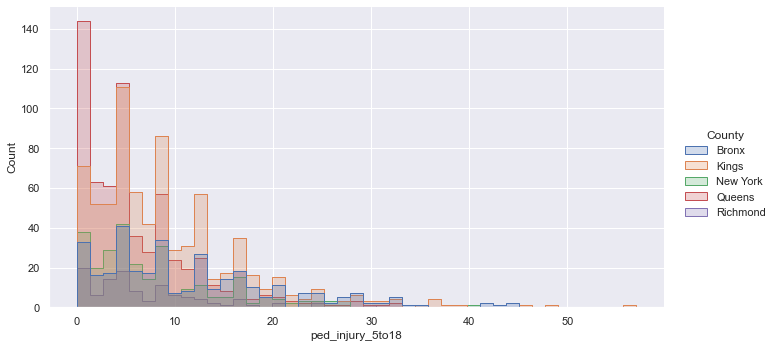

In [93]:
# Number of injuries pr county
sns.set(style="darkgrid")
sns.set(rc={'figure.figsize':(20,14)})
sns.displot(df_viz, x="ped_injury_5to18", hue="County", stat="probability", aspect=19.7/10.27)
sns.displot(df_viz, x="ped_injury_5to18", hue="County", element="step", aspect=19.7/10.27)

Probability that there are between 0 and 10 injuries are more likely. Moreover the probability for an injuri is higher in Kings and Queens compared to New York

## Distribution of pedestrian injuries and youth population

<AxesSubplot:xlabel='ped_injury_5to18', ylabel='Count'>

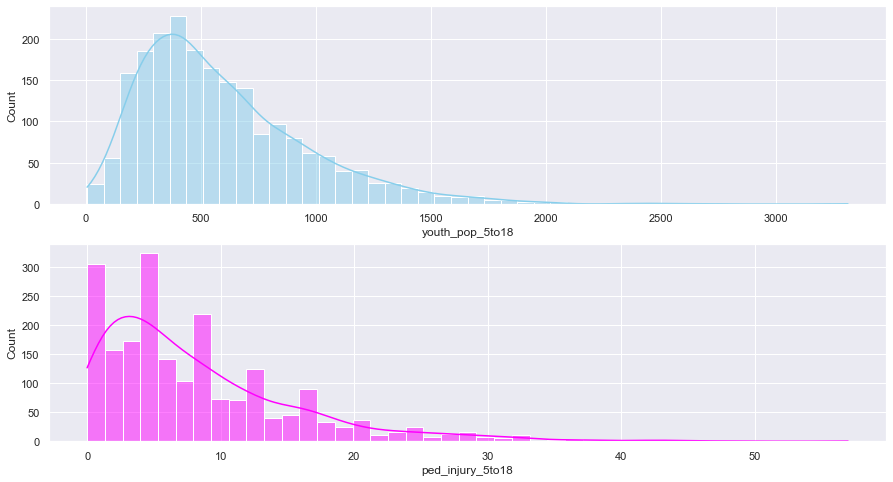

In [89]:
import seaborn as sns
sns.set(style="darkgrid")
df = sns.load_dataset("iris")

fig, axs = plt.subplots(2, 1, figsize=(15, 8))

sns.histplot(data=df_viz, x="youth_pop_5to18", kde=True, color="skyblue", ax=axs[0])
sns.histplot(data=df_viz, x="ped_injury_5to18", kde=True, color="magenta", ax=axs[1])

From the distribution plot it seems that the youth population follows a poisson distribution and that the pedestrian injuries are more spread out, however, a tendency of a poisson distribution is observed.

In [59]:
df_viz[["youth_pop_5to18","ped_injury_5to18"]].describe()

,youth_pop_5to18,ped_injury_5to18
count,2095.000000,2095.000000
mean,596.447255,8.206683
std,370.046583,7.454526
min,6.000000,0.000000
25%,326.000000,3.000000
50%,510.000000,6.000000
75%,789.500000,11.500000
max,3315.000000,57.000000


From the statistics and distribution plots it can be seen that on average the youth population is 596 and the average pedestrian injuries are 8 when considering all census tracts made.
The maximum amount of youth population corresponds to 3315 which seems to be an outlier as 75% measured a youth population of 789.

## Traffic and private vehicles

<AxesSubplot:xlabel='avg_ann_daily_traffic', ylabel='Count'>

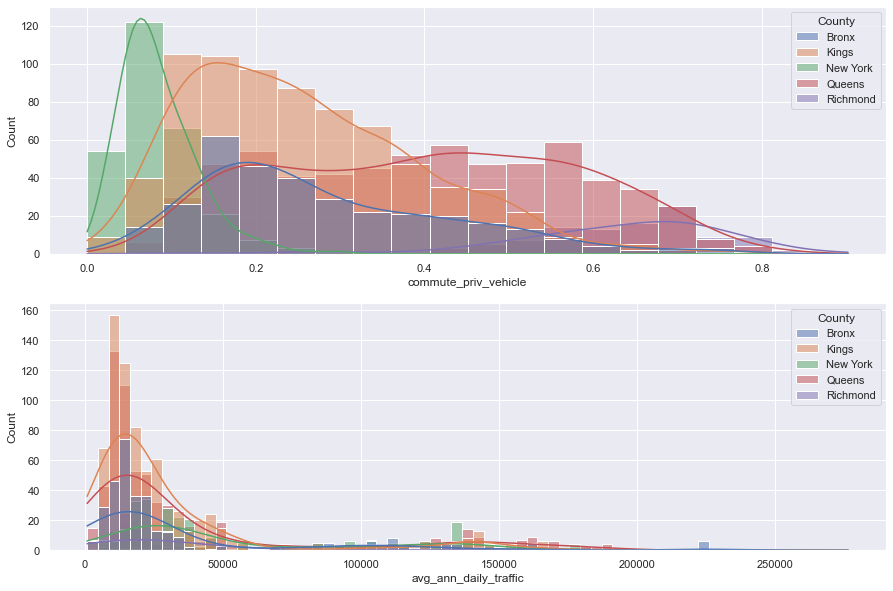

In [91]:
import seaborn as sns
sns.set(style="darkgrid")
df = sns.load_dataset("iris")

fig, axs = plt.subplots(2, 1, figsize=(15, 10))

sns.histplot(data=df_viz, x="commute_priv_vehicle", kde=True, color="purple", ax=axs[0], hue = 'County')
sns.histplot(data=df_viz, x="avg_ann_daily_traffic", kde=True, color="pink", ax=axs[1], hue = 'County')

From the distribution plots, it is observed that more people drive a private vehicle in Queens compared to New York. Moreover, it is observsed that the daily traffic is a bit higher in New York compared to the other areas, even though the traffic distributions seem to follow the same distribution overall and the areas are thus difficult to seperate based on this attribute. 

### Poverty

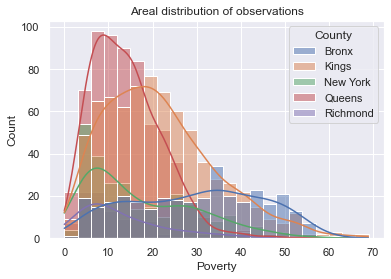

In [92]:
fig, ax = plt.subplots(1,1)

sns.histplot(df_merged, x="Poverty", binwidth=3, kde=True, hue = 'County')

plt.title("Areal distribution of observations")
plt.show()

Most census tracts show high poverty rate in Bronx and lower poverty rate in Queens. 